## Entire Script

### Package Loading

In [69]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

### Parameters 

In [70]:
import os 

### parameters 

## Generation of ground truth model 

model_name = 'updated_nn_svr_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 500 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Currently, only the 'last time point' method is used for target data generation
## In addition, only 'feedback regulation removal' is used for the suboptimal model generation

## General parameters
parallelise = True
save_figures = True 
experiment_id = model_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = 'experiments/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

### Core Script

In [71]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

### Generate the synthetic data

feature_df = generate_feature_data(model_spec, runner, feature_generation_method, feature_generation_extra_params, feature_generation_size, seed=feature_generation_seed)
initial_values = get_model_initial_values(model_spec, runner)

target_df, time_course_data = generate_target_data(model_spec, runner, feature_df, initial_values)

### Generate the suboptimal model

NR = no_feedback_regulations
sub_regulations = model_spec.regulations[NR:]
sub_reg_types = model_spec.regulation_types[NR:]
copy_model_spec = deepcopy(model_spec)
copy_model_spec.regulations = sub_regulations
copy_model_spec.regulation_types = sub_reg_types
S0 = copy_model_spec.generate_network('SuboptimalModel', (5, 5000), (0.1, 10), (0.7, 1.3), random_seed=o_random_seed, verbose=0)

G_params = G0.parameters.copy()
G_states = G0.states.copy()
for p in G_params:
    if p in S0.parameters:
        S0.parameters[p] = G0.parameters[p]

for s in G_states:
    if s in S0.states:
        S0.states[s] = G0.states[s]
        
runner_sub = roadrunner.RoadRunner(S0.get_sbml_model())
        
### Validation step - generation of engineered feature data using ground truth model

# obtain the last time point for each phosphorylated species
all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
all_phos_species = [s+'p' for s in all_species]

all_time_course_data_G0 = generate_model_timecourse_data(model_spec, runner, feature_df, initial_values)
all_time_course_data_phos_G0 = all_time_course_data_G0[all_phos_species]
last_time_points_G0 = all_time_course_data_phos_G0.applymap(lambda x: x[-1])

### Generate the engineered feature data

all_time_course_data_S0 = generate_model_timecourse_data(model_spec, runner_sub, feature_df, initial_values)
all_time_course_data_phos_S0 = all_time_course_data_S0[all_phos_species]
last_time_points_S0 = all_time_course_data_phos_S0.applymap(lambda x: x[-1])

engineered_feature_df = last_time_points_S0.copy()
combined_feature_df = pd.concat([feature_df, engineered_feature_df], axis=1)


### Using machine learning models to predict the target data

# create a function to evaluate the model performance 

def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # print('--- Model:', model)
    # print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    # print('R2 Score:', r2_score(y_test, y_pred))
    # print('Pearson Correlation:', pearsonr(y_test, y_pred)[0], pearsonr(y_test, y_pred)[1])
    # return model
    
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }


# create a linear regression model
lm = LinearRegression()

# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)

# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)

# create a support vector machine model
svr = SVR(max_iter=10000)

scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])

# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)

scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = [feature_df, engineered_feature_df, combined_feature_df]
all_features_desc = ['Feature Data', 'Engineered Feature Data', 'Combined Feature Data']
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in zipped_feature_data:
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df
    

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,Feature Data,381.247126,0.566203,0.758749,1.025540e-38
1,Linear Regression,Feature Data,300.565977,0.667492,0.818823,1.289031e-49
2,Linear Regression,Feature Data,357.105617,0.570690,0.756160,2.558733e-38
3,Linear Regression,Feature Data,400.578574,0.603648,0.776968,1.169279e-41
4,Linear Regression,Feature Data,261.578397,0.743256,0.864231,5.527547e-61
...,...,...,...,...,...,...
145,Neural Network,Combined Feature Data,44.100575,0.951939,0.976178,2.349280e-133
146,Neural Network,Combined Feature Data,56.706239,0.933614,0.966684,3.894857e-119
147,Neural Network,Combined Feature Data,60.206485,0.937369,0.968868,5.273914e-122
148,Neural Network,Combined Feature Data,59.677772,0.938941,0.969091,2.614102e-122


### Figure Generation and Visualisation

#### Cp and C in ground truth model

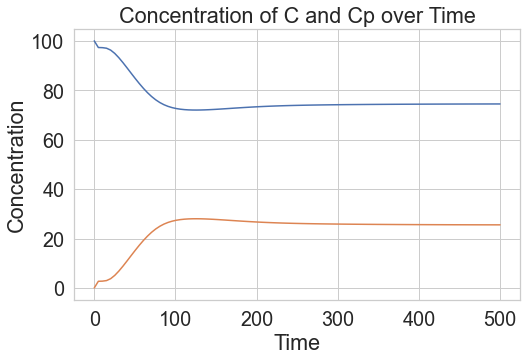

In [72]:
# === PLOT: Visible States Over Time ===

# Initialize RoadRunner and simulate the model
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

# Define key observable states
visible_states = ['C', 'Cp']

# Plot the concentration of visible states over time
plt.figure(figsize=(8, 5))
for state in visible_states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of C and Cp over Time")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_01_C_Cp_time_course_ground_truth.png')
plt.show()

#### All species in ground truth model

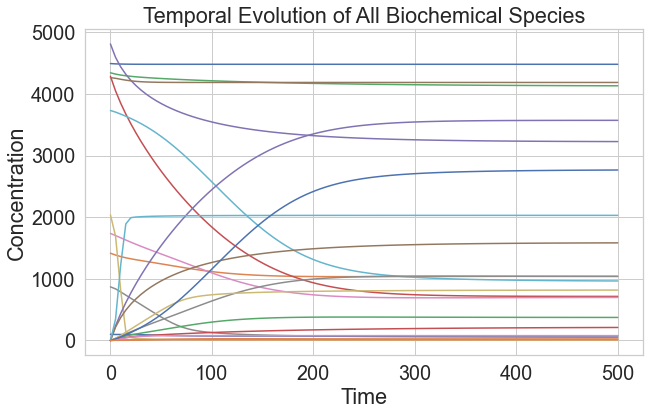

In [73]:
# === PLOT: All Biochemical Species Over Time ===

plt.figure(figsize=(10, 6))

states = model_spec.A_species + model_spec.B_species + model_spec.C_species
# plus the phosphorylated species
states += [s+'p' for s in states]
for state in states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Temporal Evolution of All Biochemical Species")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_02_all_species_time_course_ground_truth.png')
plt.show()

#### Species versus their phosphorylated forms in Ground Truth Model

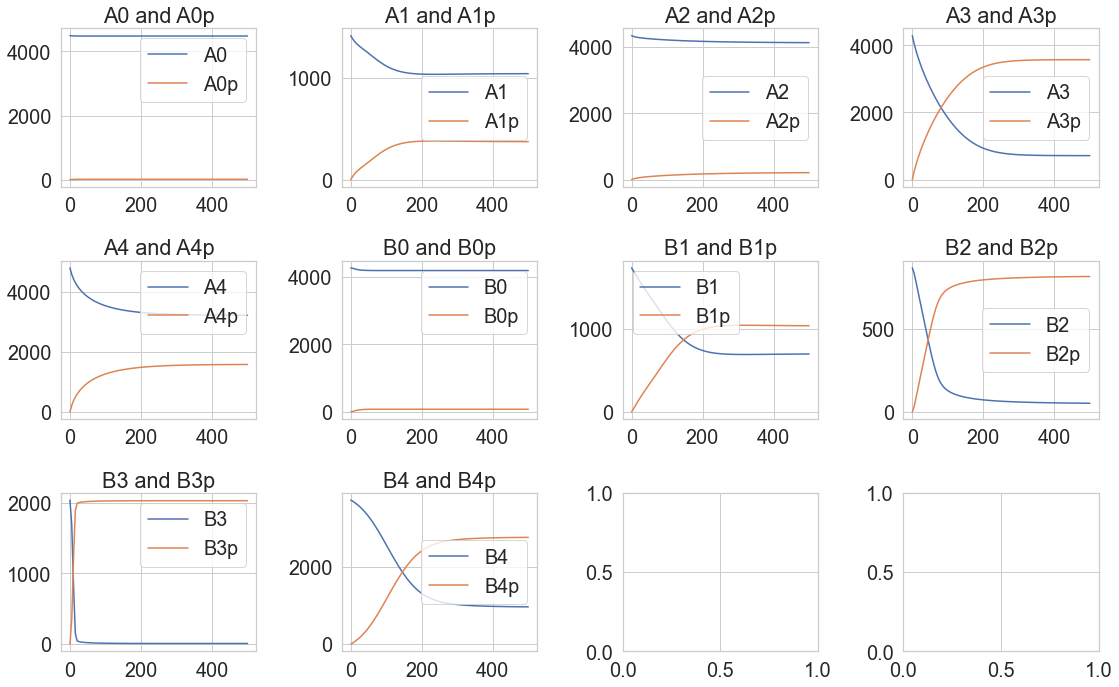

In [74]:
# === MULTI-PLOT: Species vs. Phosphorylated Forms ===
AandB = model_spec.A_species + model_spec.B_species  # Select key species

columns = 4
fig, axs = plt.subplots(len(AandB) // columns + 1, columns, figsize=(4 * columns, 5 * (len(AandB) // columns)))

for i, specie in enumerate(AandB):
    row, col = i // columns, i % columns
    specie_phos = specie + 'p'  # Identify phosphorylated form

    axs[row, col].plot(res['time'], res[f'[{specie}]'], label=specie)
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos)
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()

plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_03_species_vs_phosphorylated_forms_ground_truth.png')

plt.show()

####  Simulations of the Ground Truth Model based on feature data

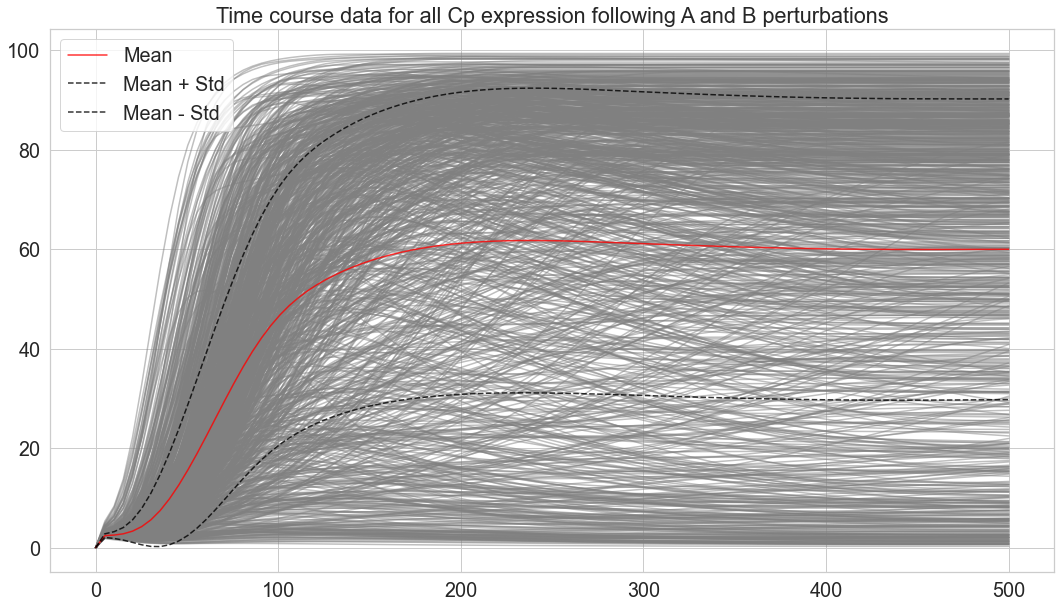

In [75]:
# plot the time course data
time_course_data = np.array(time_course_data)
time_course_data.shape

plt.title('Time course data for all Cp expression following A and B perturbations')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.legend()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_04_time_course_feature_data.png')
plt.show()

#### Cp (Target) of the Ground Truth Model versus the Sub-Optimal Model

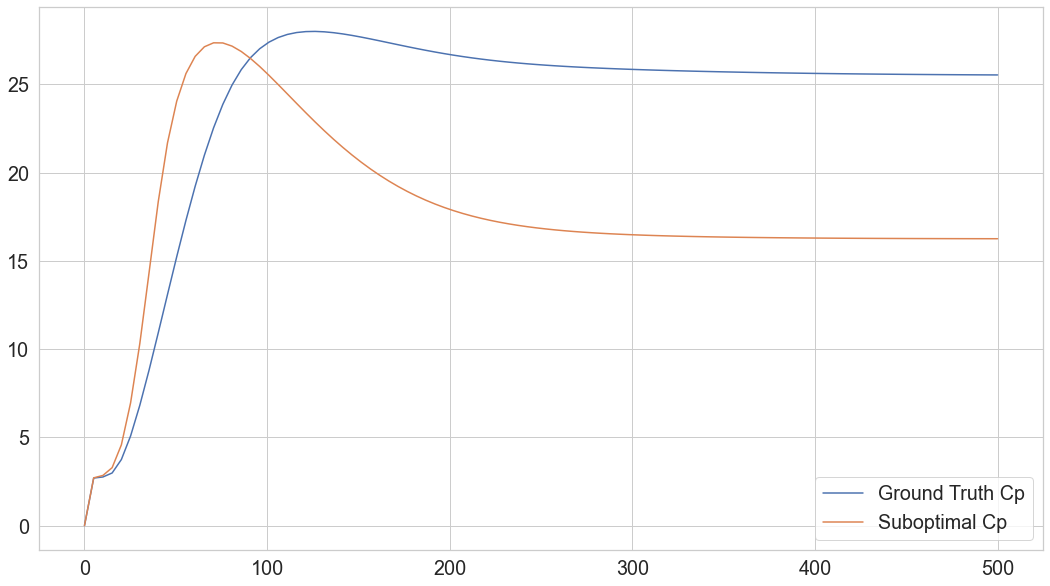

In [76]:
# make a sub-plot for the ground truth model and the suboptimal model, showing the Cp expression for C

runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, 500, 100)

runner_sub = roadrunner.RoadRunner(S0.get_sbml_model())
res_sub = runner_sub.simulate(0, 500, 100)

plt.plot(res['time'], res['[Cp]'], label='Ground Truth Cp')
plt.plot(res_sub['time'], res_sub['[Cp]'], label='Suboptimal Cp')
plt.legend()

runner = manual_reset(runner, initial_values)
runner_sub = manual_reset(runner_sub, initial_values)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_05_Cp_expression_comparison.png')
plt.show()

#### Comparison of other species in the Ground Truth Model and the Sub-Optimal Model

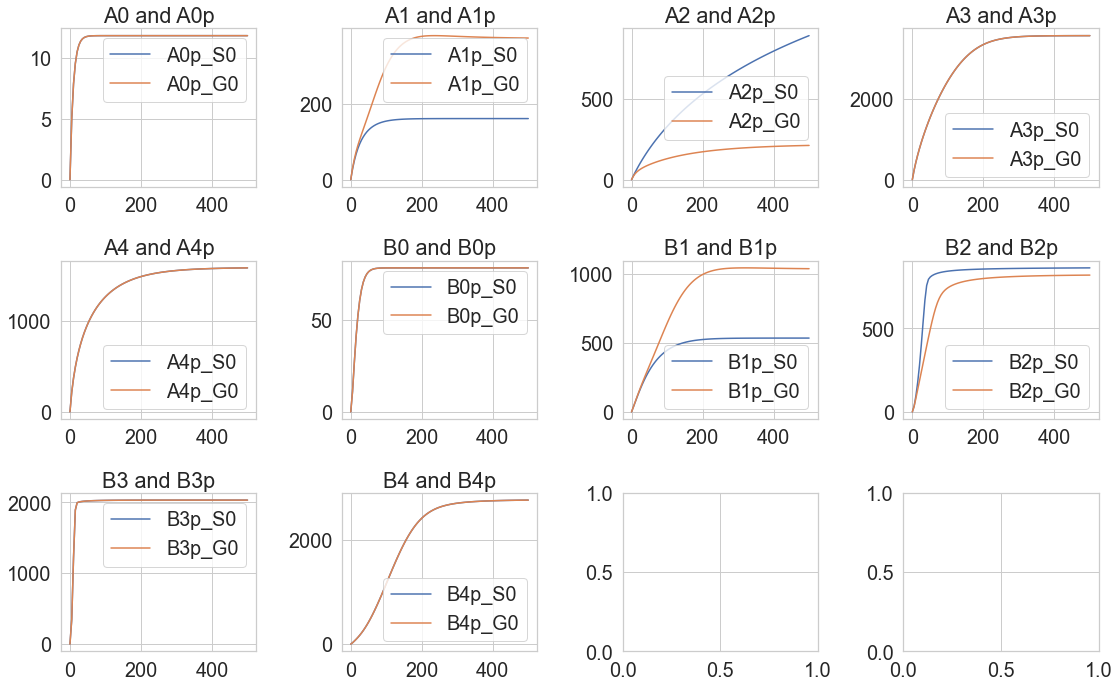

In [77]:
AandB = model_spec.A_species + model_spec.B_species
columns = 4
fig, axs = plt.subplots(len(AandB)//columns+1, columns, figsize=(4*columns, 4*len(AandB)//columns))
for i, specie in enumerate(AandB):
    row = i // columns
    col = i % columns
    # get the phosphorylated specie
    specie_phos = specie + 'p'
    # plot the specie
    # axs[row, col].plot(res_sub['time'], res_sub[f'[{specie}]'], label=specie+'_S0')
    # axs[row, col].plot(res['time'], res_sub[f'[{specie_phos}]'], label=specie+'_G0')
    axs[row, col].plot(res_sub['time'], res_sub[f'[{specie_phos}]'], label=specie_phos+'_S0')
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos+'_G0')
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()
    
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_06_species_vs_phosphorylated_forms_comparison.png')
plt.show()

#### Scatter plot between feature and target data

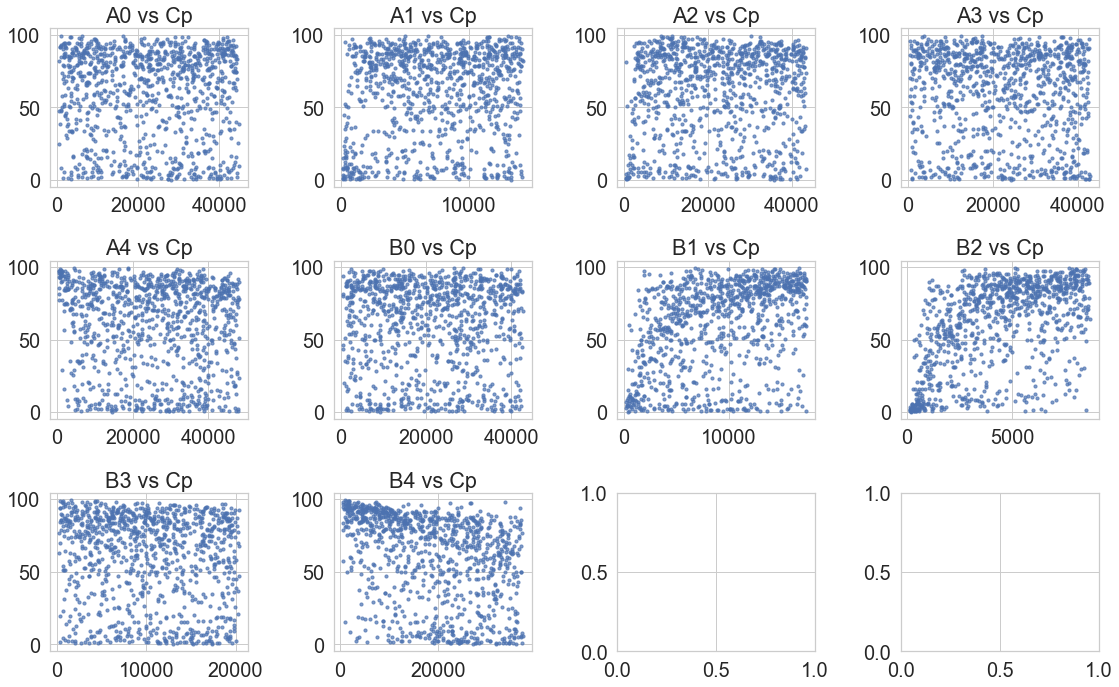

In [78]:
columns = 4
fig, axs = plt.subplots(len(feature_df.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(feature_df.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(feature_df[feature], target_df['Cp'], alpha=0.7, s=10)
    axs[row, col].set_title(f'{feature} vs Cp')
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_07_feature_vs_target.png')
plt.show()

#### Correlation matrix between feature and target data

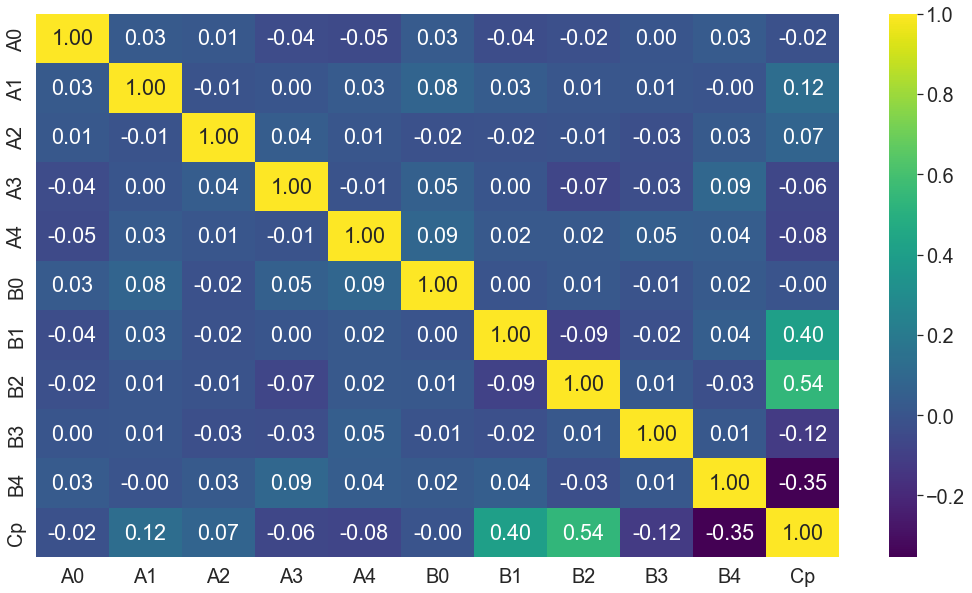

In [79]:

feature_target_df = feature_df.copy()
feature_target_df['Cp'] = target_df['Cp']
sns.heatmap(feature_target_df.corr(), annot=True, cmap='viridis', fmt=".2f")

if save_figures:
    plt.savefig(experiment_folder + 'Fig_08_feature_target_correlation.png')
plt.show()

#### Correlation matrix between last time point of ground truth model and target data

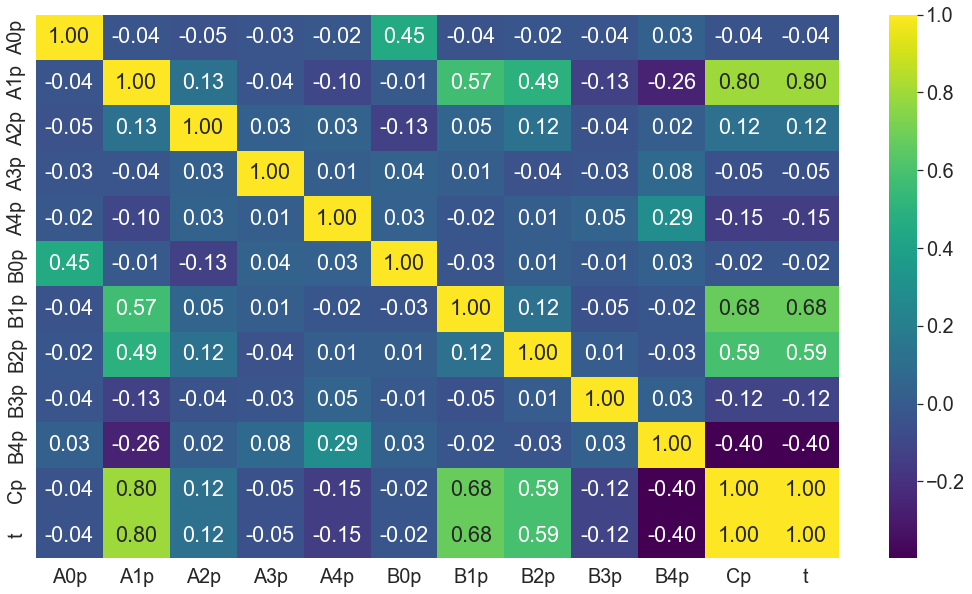

In [80]:
# perform correlation analysis between the last time points and the target data
target_last_time_points_G0 = last_time_points_G0.copy()
target_last_time_points_G0['t'] = target_df['Cp']
sns.heatmap(target_last_time_points_G0.corr(), annot=True, cmap='viridis', fmt=".2f")

if save_figures:
    plt.savefig(experiment_folder + 'Fig_09_G0_phos_last_time_point_target_correlation.png')
plt.show()

#### Scatter plot between last time point of ground truth model and target data

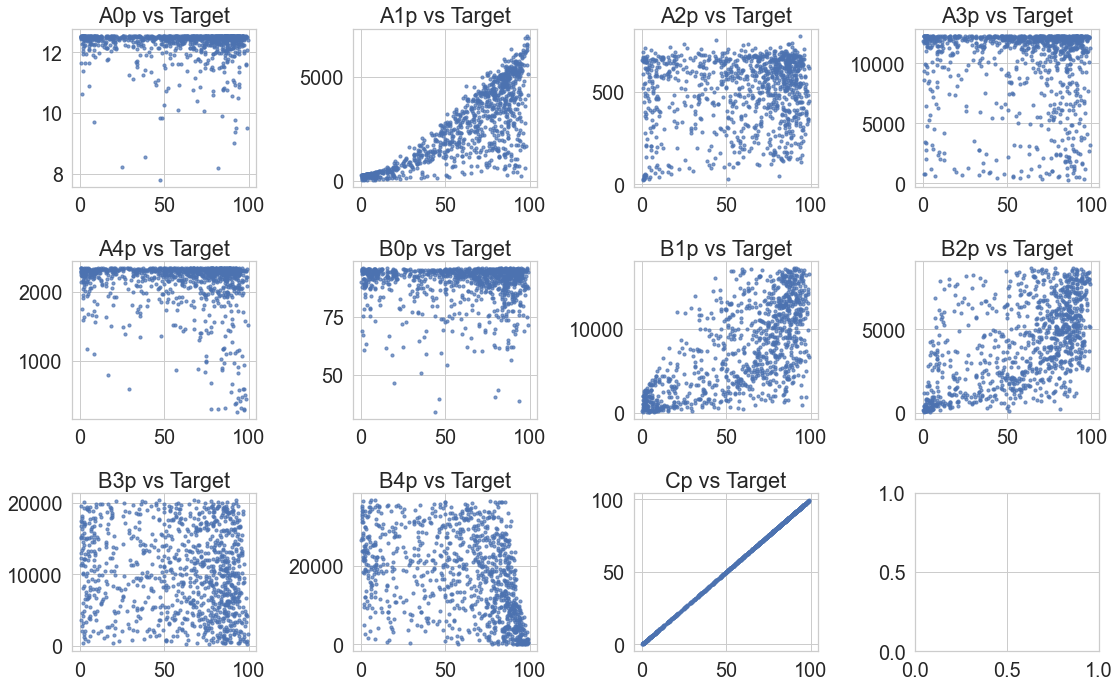

In [81]:
columns = 4
fig, axs = plt.subplots(len(last_time_points_G0.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(last_time_points_G0.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(target_df['Cp'], last_time_points_G0[feature], alpha=0.7, s=10)
    axs[row, col].set_title(f'{feature} vs Target')
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_10_G0_phos_last_time_point_vs_target_scatter.png')
plt.show()

#### Correlation matrix between last time point of sub-optimal model and target data

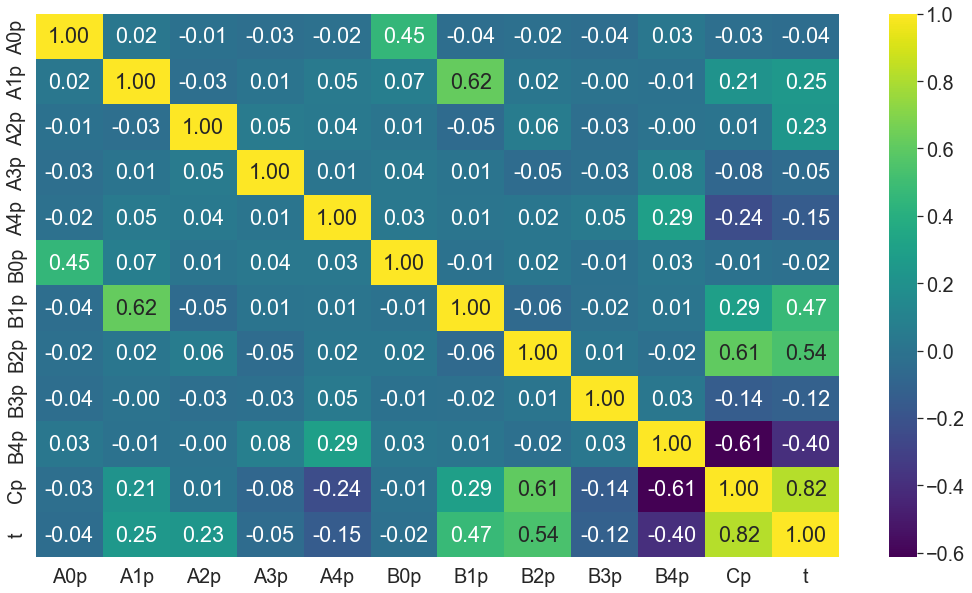

In [82]:
target_last_time_points_S0 = last_time_points_S0.copy()
target_last_time_points_S0['t'] = target_df['Cp']
sns.heatmap(target_last_time_points_S0.corr(), annot=True, cmap='viridis', fmt=".2f")
if save_figures:
    plt.savefig(experiment_folder + 'Fig_11_S0_phos_last_time_point_target_correlation.png')
plt.show()

#### Scatter plot between last time point of sub-optimal model and target data

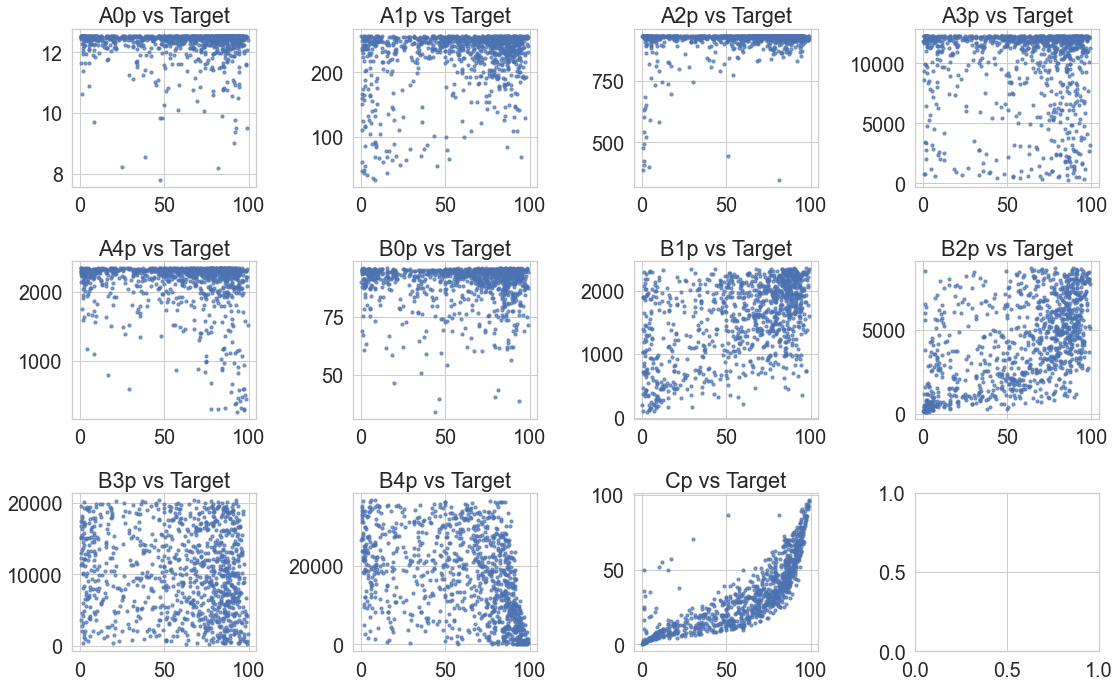

In [83]:
columns = 4
fig, axs = plt.subplots(len(last_time_points_S0.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(last_time_points_S0.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(target_df['Cp'], last_time_points_S0[feature], alpha=0.7, s=10)
    axs[row, col].set_title(f'{feature} vs Target')
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_12_S0_phos_last_time_point_vs_target_scatter.png')
plt.show()

#### Pearson Correlation of model prediction versus target data in all models

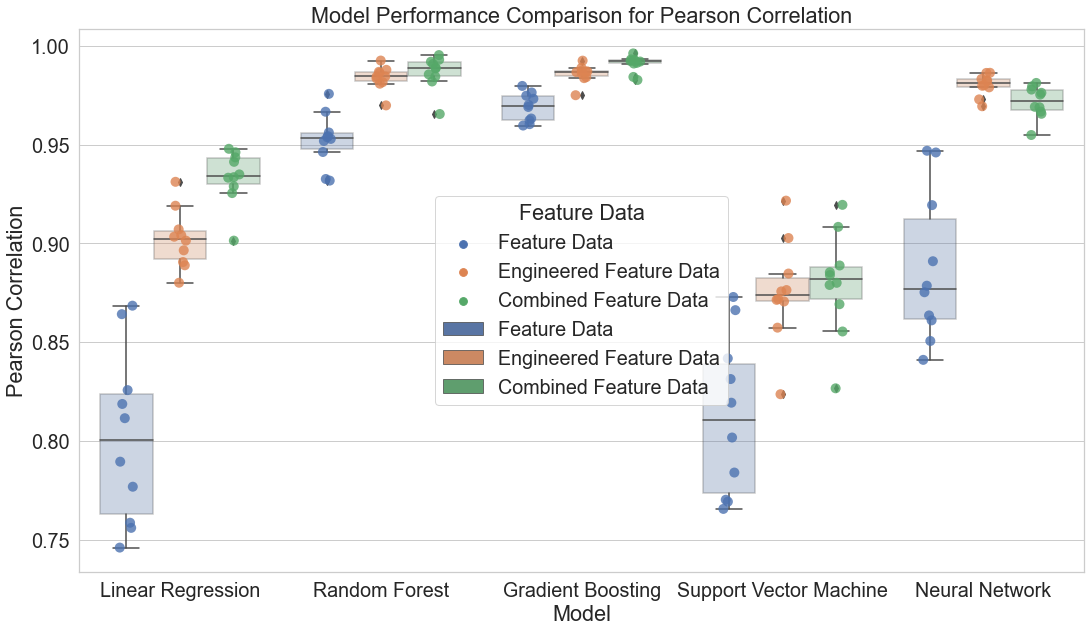

In [84]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

#### Mean Squared Error of model prediction versus target data in all models

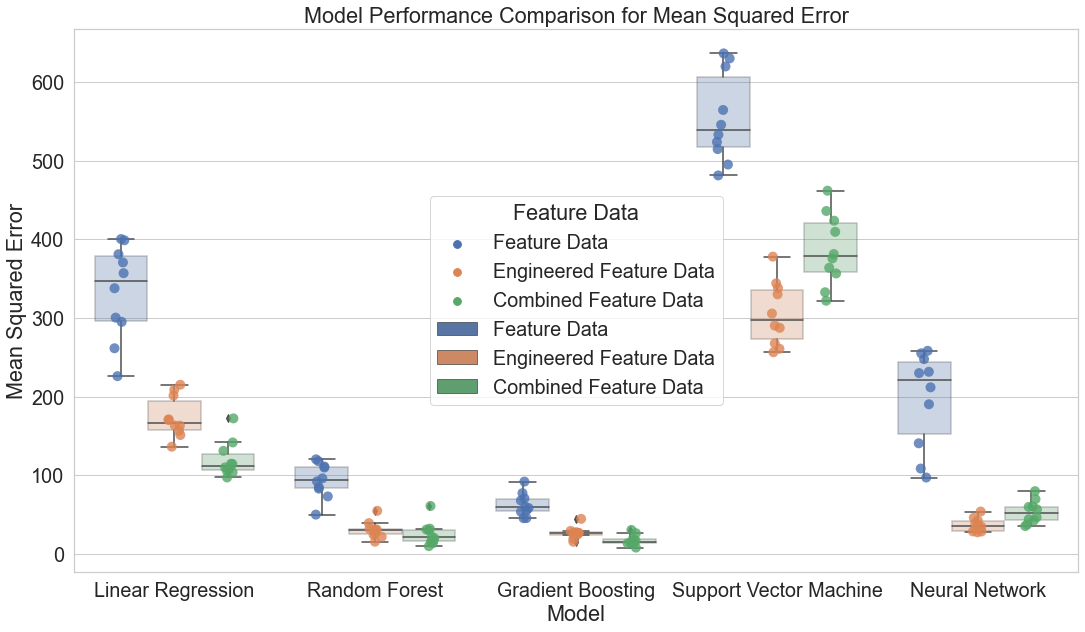

In [92]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()

### Key data outputs

#### Ground Truth Model Specification

In [87]:
print(model_spec)

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4')]
Regulation Types: ['up', 'down', 'up', 'up', 'up', 'up', 'up']
C Weak Stimulators: 2
C Strong Stimulators: 0
C Allosteric Inhibitors: 1
C Competitive Inhibitors: 2



#### Antimony Model of Ground Truth Model

In [88]:
print(G0.get_antimony_model())

model updated_nn_svr_small_model_52

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; (J3_Vmax+Cp*J3_Kw0)*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km*(1+B0p*J5_Kic0) + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+A3p*J17_Kw0)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_Vmax+A4p*J19_Kw0)*B4/(J19_Km + B4)
J20: C -> Cp; (J20_Vmax+B0p*J20_Kw0

#### Sub-Optimal Model Specification

In [89]:
print(copy_model_spec)

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4')]
Regulation Types: ['up', 'up', 'up', 'up', 'up']
C Weak Stimulators: 2
C Strong Stimulators: 0
C Allosteric Inhibitors: 1
C Competitive Inhibitors: 2



#### Antimony Model of Sub-Optimal Model

In [90]:
print(S0.get_antimony_model())  

model SuboptimalModel

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+A3p*J17_Kw0)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_Vmax+A4p*J19_Kw0)*B4/(J19_Km + B4)
J20: C -> Cp; (J20_Vmax+B0p*J20_Kw0+B1p*J20_Kw1)*C/(J20_Km*(1+B3p*J20_Kic0+B4

#### All model performance metrics

In [91]:
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,Feature Data,381.247126,0.566203,0.758749,1.025540e-38
1,Linear Regression,Feature Data,300.565977,0.667492,0.818823,1.289031e-49
2,Linear Regression,Feature Data,357.105617,0.570690,0.756160,2.558733e-38
3,Linear Regression,Feature Data,400.578574,0.603648,0.776968,1.169279e-41
4,Linear Regression,Feature Data,261.578397,0.743256,0.864231,5.527547e-61
...,...,...,...,...,...,...
145,Neural Network,Combined Feature Data,44.100575,0.951939,0.976178,2.349280e-133
146,Neural Network,Combined Feature Data,56.706239,0.933614,0.966684,3.894857e-119
147,Neural Network,Combined Feature Data,60.206485,0.937369,0.968868,5.273914e-122
148,Neural Network,Combined Feature Data,59.677772,0.938941,0.969091,2.614102e-122
